# Make the hourly weather and traffic db
I plan to do the following here
- pull in all of the hourly weather from 2015 to 2020 from openweather
- pull in all of the traffic from chicago data portal
- merge the two with a date as primary key
- also include cols for year month day

I will need to go back and do the following:
- add a shared key between traffic and 

In [241]:
#!/usr/bin/env python

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
from sodapy import Socrata
import numpy as np
from scipy import stats
import seaborn as sns



In [242]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db


In [243]:
sql_fetch_tables(c, conn)

[('cam_startend',), ('cam_locations',), ('intersection_locations',), ('daily_violations',), ('hourly_congestion',), ('congestion_regions',), ('hourly_weather',), ('intersection_cams',), ('signal_crashes',)]


In [244]:
regions_df = pd.read_sql_query("SELECT * FROM congestion_regions", conn)
congestion_df = pd.read_sql_query("SELECT * FROM hourly_congestion", conn)
weather_df = pd.read_sql_query("SELECT * FROM hourly_weather", conn)
crash_df = pd.read_sql_query("SELECT * FROM signal_crashes", conn)

In [245]:
regions_df.head()

,region,region_id,west,east,south,north,description
0,Lawndale N/S,14,-87.747456,-87.685372,41.822792,41.866129,Pershing to Roosevel. Cicero to Western
1,Washington Hts-Roseland-Pullman,26,-87.662508,-87.584845,41.677477,41.728472,119th to 91st. Ashland to Stony Island
2,Chicago Loop,13,-87.647208,-87.623080,41.866129,41.888860,Roosevelt to Wacker: Halsted to Michigan
3,Beverly-Mt Greenwood-Morgan Park,25,-87.747456,-87.662508,41.677477,41.728472,119th to 91st. Cicero to Ashland
4,New City-Englewood-W Englewood,19,-87.683730,-87.636322,41.764066,41.822792,71st to Pershing. Western to Steward


In [246]:
congestion_df.head()

,year,month,day,hour,region_id,day_of_week,speed
0,2015,1,1,0,1,5,27.455000
1,2015,1,1,0,10,5,25.796667
2,2015,1,1,0,11,5,25.816667
3,2015,1,1,0,12,5,18.636667
4,2015,1,1,0,13,5,20.681667


In [247]:
weather_df.head()

,temp,rain_1h,rain_3h,snow_1h,snow_3h,time,year,month,day,hour
0,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0
1,267.926,0.0,0.0,0.0,0.0,2015-01-01 01:00:00+00:00,2015,1,1,1
2,268.098,0.0,0.0,0.0,0.0,2015-01-01 02:00:00+00:00,2015,1,1,2
3,268.157,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3
4,268.121,0.0,0.0,0.0,0.0,2015-01-01 04:00:00+00:00,2015,1,1,4


In [248]:
print('Total potential wx entries:', len(weather_df) * 29)  # if every weather entry had every region
print('Total congestion entries:', len(congestion_df))
print()

for year in range(2015, 2021):
    print(year, 'traffic entries:', len(congestion_df[congestion_df['year']==year]))
    print(year, 'weather entries:', len(weather_df[weather_df['year']==year]) * 29)
    print()
    

# we have more wx data than congestion.  Consider dropping 2015?
# it makes sense to have slightly more weather entries.  
# Not all regions have buses running 24/7.  Could also have missing data

Total potential wx entries: 1601351
Total congestion entries: 1337103

2015 traffic entries: 88740
2015 weather entries: 267119

2016 traffic entries: 250473
2016 weather entries: 267670

2017 traffic entries: 251517
2017 weather entries: 268221

2018 traffic entries: 254388
2018 weather entries: 270628

2019 traffic entries: 242208
2019 weather entries: 275065

2020 traffic entries: 249777
2020 weather entries: 252648



In [249]:
#weather_df.groupby(['year', 'month', 'day', 'hour']).reset_index().info()

In [250]:
pd.merge(weather_df, congestion_df, how='right', on=['year', 'month', 'day', 'hour']).head(100)  # minutes

,temp,rain_1h,rain_3h,snow_1h,snow_3h,time,year,month,day,hour,region_id,day_of_week,speed
0,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,1,5,27.455000
1,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,10,5,25.796667
2,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,11,5,25.816667
3,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,12,5,18.636667
4,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,13,5,20.681667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,268.157,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3,17,5,0.000000
96,268.157,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3,18,5,30.596667
97,268.157,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3,19,5,30.200000
98,268.157,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3,2,5,9.903333


# Congestion by hour
Overnight data is not available for all regions.  We need to fill in the missing data

In [315]:
# clean up congestion to fill in the missing overnight data with mean
congestion_df.speed.isna().sum()

print('Congestion')
print('Rows with speed of zero: {:.2f}%'.format(congestion_df[congestion_df['speed']==0].count()[0] / len(congestion_df) * 100))



def speed_fix(speed, hour):
    # there is no significant congestion before 5am in Chicago.
    # there are however a significant amount of buses sitting still before starting routes
    if speed < 20 and 0 < hour < 5 or speed > 50:
        return 28
    else:
        return speed

#congestion_df.speed.replace(0, congestion_df.speed.mean(), inplace=True)
# takes a few minutes to fix the speed discrepancy  

############### MOVE ME TO PREPROCESSING  ######################
congestion_df['speed'] = congestion_df.apply(lambda x: speed_fix(x.speed, x.hour), axis=1)


Congestion
Rows with speed of zero: 0.59%


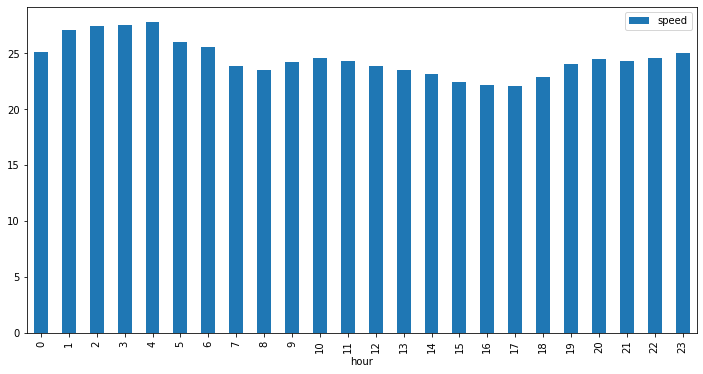

In [317]:
congestion_df.groupby('hour').agg({'speed': np.mean}).reset_index().plot.bar(x='hour', y='speed', figsize=(12,6))

# Congestion and crashes

In [318]:
all_df = pd.merge(weather_df, congestion_df, how='right', on=['year', 'month', 'day', 'hour'])  # minutes

In [319]:
all_df.head()

,temp,rain_1h,rain_3h,snow_1h,snow_3h,time,year,month,day,hour,region_id,day_of_week,speed
0,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,1,5,27.455000
1,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,10,5,25.796667
2,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,11,5,25.816667
3,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,12,5,18.636667
4,267.708,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,13,5,20.681667


In [320]:
crash_df['crash_date'] = pd.to_datetime(crash_df['crash_date'])
crash_df['year'] = crash_df['crash_date'].apply(lambda x: int(x.year))
crash_df['month'] = crash_df['crash_date'].apply(lambda x: int(x.month))
crash_df['day'] = crash_df['crash_date'].apply(lambda x: int(x.day))
crash_df['hour'] = crash_df['crash_date'].apply(lambda x: int(x.hour))


In [321]:
crash_df['crash_date'].min()  # no reports prior to this date.  Uh-oh!

Timestamp('2015-08-02 19:55:00')

In [322]:

def get_crashes(year, month, day, hour, region_id):
    # crash df is defined globally
    count = len(crash_df[(crash_df['year']==year) & 
                         (crash_df['month']==month) & 
                         (crash_df['day']==day) & 
                         (crash_df['hour']==hour) &
                         (crash_df['region_id']==region_id)
                        ])
    return count


i = 2
print(all_df.iloc[i]['year'])


all_df[8000:8050].apply(lambda x: get_crashes(x.year,x.month,x.day,x.hour, x.region_id), axis=1).head(50)
all_df['n_crash'] = all_df.apply(lambda x: get_crashes(x.year,x.month,x.day,x.hour, x.region_id), axis=1)
           

# UGH, this takes forever

2015


KeyboardInterrupt: 

In [ ]:
# can I use sql to combine crashes and weather
sql_fetch_tables(c, conn)


'''
Example
SELECT
  s.last_name, s.first_name,
  p.course_code, p.status, p.amount
FROM enrollment e
JOIN student s
  ON s.id=e.student_id
JOIN payment p
  ON p.course_code=e.course_code
    AND p.student_id=e.student_id;
'''

big_df = pd.read_sql_query('''SELECT * 
                              FROM hourly_congestion c
                              LEFT JOIN hourly_weather wx
                                  ON c.year=wx.year
                                     AND c.month=wx.month
                                     AND c.day=wx.day
                                     AND c.hour=wx.hour
                              LEFT JOIN signal_crashes cr
                                 ON c.year=cr.year
                                     AND c.month=cr.month
                                     AND c.day=cr.day
                                     AND c.hour=cr.hour
                                     AND c.region_id=cr.region_id
                              WHERE c.year BETWEEN 2016 AND 2020

                           ''', conn)


big_df.head()

In [ ]:
big_df.info()
congestion_df.info()

# if two or more crashes occur in the same region in same hour, we have mutliple entries.  
# We can groupby to fix this if we need to plot, just be aware.  There are about 5k of them

In [ ]:
# would like to add how many crashes for every hour last 5 years
# would like to add if it was at a rlc (Should be there now)
# need to add is_active for rlc for every hour

In [ ]:
# EDA to show

# CRASHES
# by congestion (binned)
# by day of week
# by month
# by temp
# by precip
# by rlc present

# CONGESTION
# by day of week
# by month
# by temp
# by precip

# RED LIGHT VIOLATIONS
# violations by month
# violations by day of week

# MODEL
# linear model with target of crashes
# do single variable regression of all of my variables
# vars

Average congestion (speed) for all signal crashes: 22.02 mph 
Standard deviation (speed: 5.06)


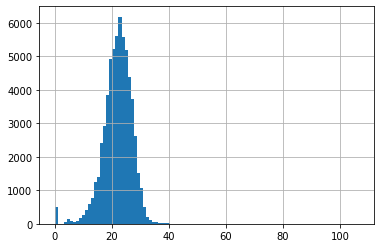

In [352]:
big_df[big_df['crash_record_id'].notnull()]['speed'].hist(bins=100)
print('Average congestion (speed) for all signal crashes: {:.2f} mph \nStandard deviation (speed: {:.2f})'
      .format(big_df[big_df['crash_record_id'].notnull()]['speed'].mean(),
              big_df[big_df['crash_record_id'].notnull()]['speed'].std()
             ))


In [ ]:
# Compare this to all congestions
big_df['speed'].hist(bins=100)
plt.show()
big_df.boxplot(column=['speed'])

print('Average congestion (speed) all entries: {:.2f} mph\nStandard deviation (speed): {:.2f} '
      .format(big_df['speed'].mean(), big_df['speed'].std()))


In [ ]:
# Congestion may have some affect on accidents


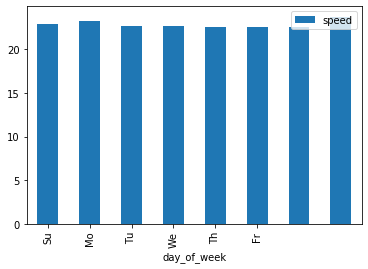

In [343]:
# Congestion by day of week
##### NEED TO FIX DAY OF WEEK IN PREPROCESSING

xticks = ['Su','Mo','Tu','We','Th','Fr','Sa']
ax = big_df.groupby('day_of_week').mean().reset_index().plot.bar('day_of_week','speed')

ax.set_xticks(range(6))
ax.set_xticklabels(xticks)
plt.show()

In [350]:
big_df = big_df.loc[:,~big_df.columns.duplicated()]  # remove dupe columns


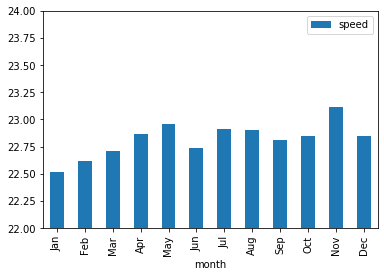

In [387]:
xticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = big_df.groupby('month').mean().reset_index().plot.bar('month','speed')

ax.set_xticks(range(12))
ax.set_xticklabels(xticks)
ax.set_ylim(22,24)
plt.show()

Crash only temperature data
count    60951.000000
mean       285.758031
std         11.362269
min        245.370000
25%        276.480000
50%        285.350000
75%        295.370000
max        310.370000
Name: temp, dtype: float64

All temperature data
count    1.311840e+06
mean     2.856057e+02
std      1.104376e+01
min      2.453700e+02
25%      2.764800e+02
50%      2.851500e+02
75%      2.951500e+02
max      3.114800e+02
Name: temp, dtype: float64


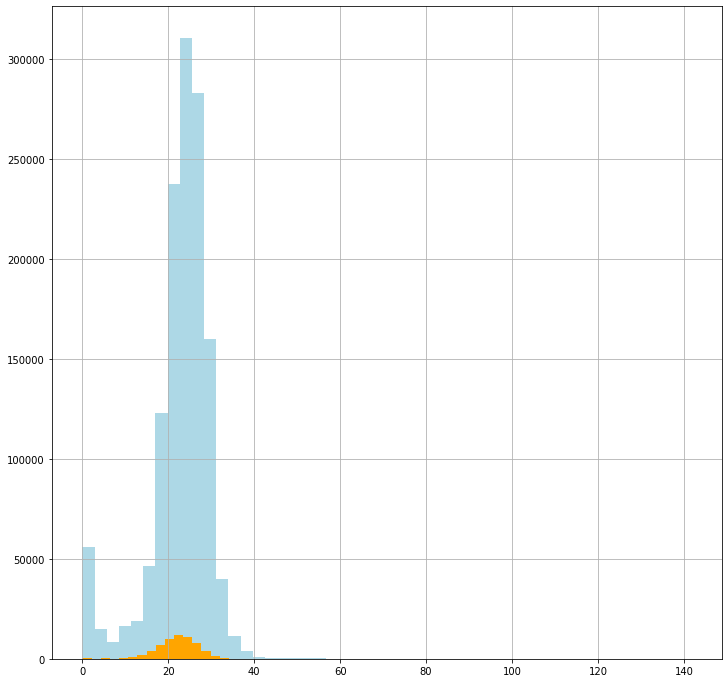

In [394]:
# how does congestion change with weather

#xticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
big_df['speed'].hist(bins=50, color='lightblue')

big_df[big_df['crash_record_id'].notnull()]['speed'].hist(bins=50, figsize=[12,12], color='orange')

#ax.set_xticks(range(12))
#ax.set_xticklabels(xticks)

print("Crash only temperature data")
print(big_df[big_df['crash_record_id'].notnull()]['temp'].describe())
print()
print("All temperature data")
print(big_df['temp'].describe())

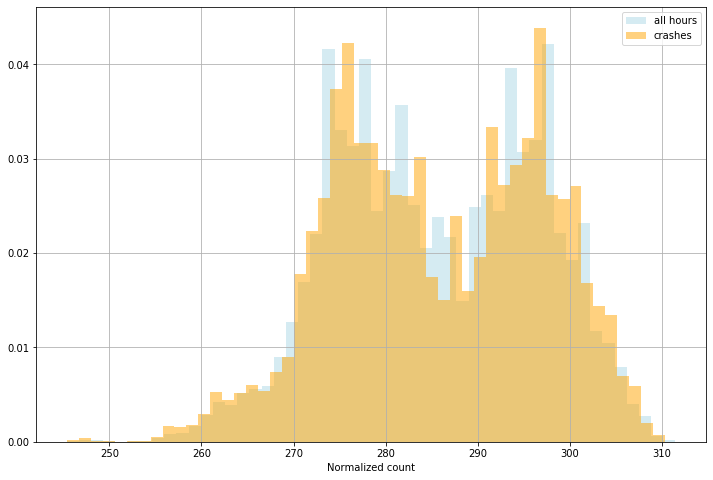

In [404]:
# same thing scaled


# Now, we are normalizing the dataframe (df) by using fit_transform function of MinMaxScaler and making the dataframe of the normalized array.



big_df['temp'].hist(bins=50, color='lightblue', normed=True, alpha=0.5, label='all hours')

big_df[big_df['crash_record_id'].notnull()]['temp'].hist(bins=50, figsize=[12,8], color='orange', normed=True, alpha=0.5, label='crashes')

#big_df[big_df['crash_record_id'].notnull()]['temp'].hist(bins=50, figsize=[12,12], color='orange')
#ax.set_yscale('log')
plt.legend()
plt.xlabel('Temperature (K)')
plt.xlabel('Normalized count')

plt.show()

In [405]:
big_df.columns

Index(['year', 'month', 'day', 'hour', 'region_id', 'day_of_week', 'speed',
       'temp', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'time',
       'crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'hit_and_run_i', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'crash_date_est_i', 'work_zon

In [451]:
# Same thing, now with precipitation
# same thing scaled 
big_df['precip_3h'] = big_df['rain_3h'] + big_df['snow_3h']
big_df['is_precip'] = big_df['precip_3h'].apply(lambda x: True if x>0 else False)

big_df['precip_1h'] = big_df['rain_1h'] + big_df['snow_1h']
big_df['is_precip1'] = big_df['precip_1h'].apply(lambda x: True if x>0 else False)

print('Average precipitation all hours (mm):      {:.4f}'.format(big_df['precip_1h'].mean()))
print('Average precipitation during crashes (mm): {:.4f}'.format(big_df[big_df['crash_record_id'].notnull()]['precip_1h'].mean()))
print()

print('Percentage of hours with precipitation in prev hour:   {:.4f}%'
            .format(big_df['is_precip1'].sum()*100/len(big_df)))
print('Percentage of crashes with precipitation in prev hour: {:.4f}%'
            .format(big_df[big_df['crash_record_id'].notnull()]['is_precip1']
            .sum()*100/len(big_df[big_df['crash_record_id'].notnull()])))

big_df['is_rain'] = big_df['rain_1h'].apply(lambda x: True if x>0 else False)
print()
print('Percent hours with rain:   {:.4f}%'
            .format(big_df['is_rain'].sum()*100/len(big_df)))
print('Percentage crashes with rain: {:.4f}%'
            .format(big_df[big_df['crash_record_id'].notnull()]['is_rain']
            .sum()*100/len(big_df[big_df['crash_record_id'].notnull()])))



big_df['is_snow'] = big_df['snow_1h'].apply(lambda x: True if x>0 else False)
print()
print('Percentage of hours with snow in prev hour:    {:.4f}%'
            .format(big_df['is_snow'].sum()*100/len(big_df)))
print('Percentage of crashes with snow in prev hour:  {:.4f}%'
            .format(big_df[big_df['crash_record_id'].notnull()]['is_snow']
            .sum()*100/len(big_df[big_df['crash_record_id'].notnull()])))
# Fairly obvious correlation between precipitation and accidents at intersections

Average precipitation all hours (mm):      0.1790
Average precipitation during crashes (mm): 0.1967

Percentage of hours with precipitation in prev hour:   14.6075%
Percentage of crashes with precipitation in prev hour: 16.0989%

Percentage of hours with rain in prev hour:   12.2981%
Percentage of crashes with rain in prev hour: 13.7924%

Percentage of hours with snow in prev hour:    2.6938%
Percentage of crashes with snow in prev hour:  2.6990%


In [454]:
# rlc present
print('Number of crashes at red light camera: {}'.format(big_df['rlc_present'].sum()))

big_df['rlc_present'] = big_df['intersection'].apply(lambda x: True if x else False)
print('Percent of signal crashes with red light cam present: {:.2f}%'
      .format(big_df['rlc_present'].sum() * 100 / len(big_df[big_df['crash_record_id'].notnull()])))

# turns out that most crashes are not at the intersections with rlc

Number of crashes at red light camera: 8236
Percent of signal crashes with red light cam present: 13.30%


Now let's do some analysis and modeling.
What does that look like?

Q1:  What factors affect the number of rlc violations?  **Straight forward linear regression**


Q2: What factors affect the number of crashes, and which are most important? (Linear regression?)
After some thought, I think the EDA tells me that the region and congestion will not be that usefule at a granular level.  Instead of splitting my data into 29 regions, I can just crunch it down to hourly data.  I will get 0 to 5 or so total crashes. Otherwise it is a sparse/rare event.
**This could be useful to build a linear regression.**

Q3: Using only intersections with RLC (red light cams), do they affect the number and type of crashes.  We need to know the dates they are on and off, and only use cams with periods on and off.  
We also need to use only 2014 on, so there won't be a huge amount of data to work with, maybe a few hundred.  **Could use a t-test?**


